In [1]:
import os

import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
data_arr = np.load("../data/data_unfiltered.npy")
run_arr = np.load("../data/runs_unfiltered.npy")

# Using a reference run
train_data = data_arr[run_arr == 379456]
train_data

array([[1006.,  830.,  253., ...,    0.,    0.,    0.],
       [ 788.,  653.,  221., ...,    0.,    0.,    0.],
       [ 966.,  775.,  295., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]])

In [3]:
scaler = MinMaxScaler()
scaler.fit(train_data)
norm_values = scaler.transform(train_data)

In [4]:
dtrain = xgb.DMatrix(norm_values, label=norm_values)

In [5]:
param = {
    'eta': 0.1,
    'max_depth': 5,
    'nthread': 4,
    'objective': 'reg:squarederror'
}
bst = xgb.train(params=param, dtrain=dtrain, num_boost_round=50)

In [6]:
reconstructed = bst.predict(dtrain)
reconstructed

array([[9.7633874e-01, 9.7211319e-01, 7.9456949e-01, ..., 4.8150166e-04,
        4.8150166e-04, 4.8150166e-04],
       [7.6625001e-01, 7.6715690e-01, 6.9832617e-01, ..., 4.8150166e-04,
        4.8150166e-04, 4.8150166e-04],
       [9.3966490e-01, 9.0812749e-01, 9.2423224e-01, ..., 4.8150166e-04,
        4.8150166e-04, 4.8150166e-04],
       ...,
       [1.2142446e-03, 1.1476593e-03, 1.1039738e-03, ..., 4.8150166e-04,
        4.8150166e-04, 4.8150166e-04],
       [1.2142446e-03, 1.1476593e-03, 1.1039738e-03, ..., 4.8150166e-04,
        4.8150166e-04, 4.8150166e-04],
       [1.2142446e-03, 1.1476593e-03, 1.1039738e-03, ..., 4.8150166e-04,
        4.8150166e-04, 4.8150166e-04]], dtype=float32)

In [7]:
mse = np.mean((norm_values - reconstructed)**2, axis=1)
mse

array([3.31098344e-06, 1.46530422e-06, 3.62487538e-06, ...,
       3.58790312e-07, 3.58790312e-07, 3.58790312e-07])

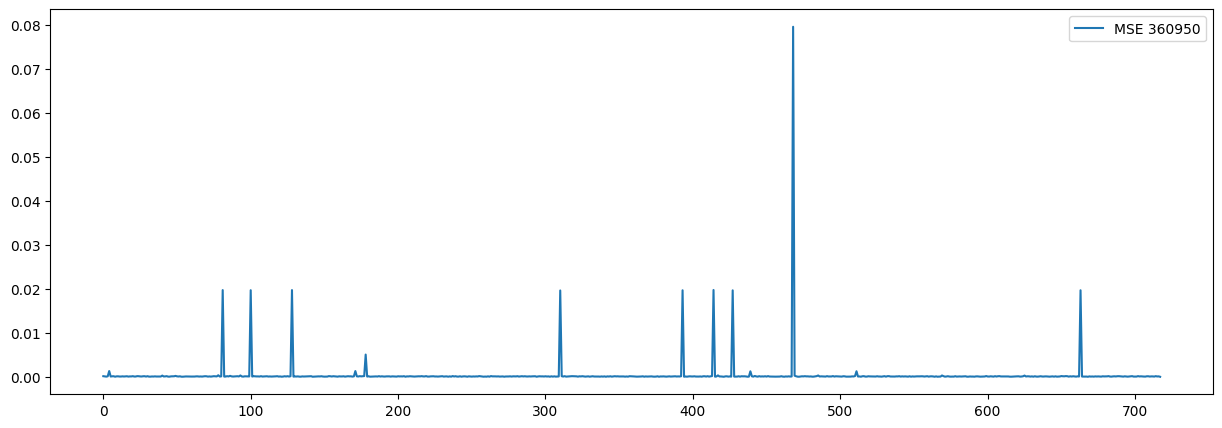

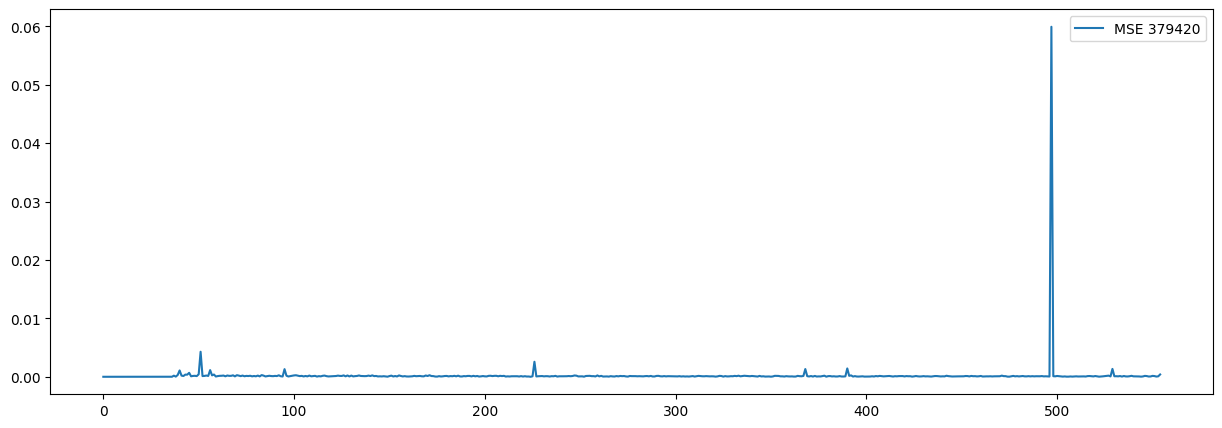

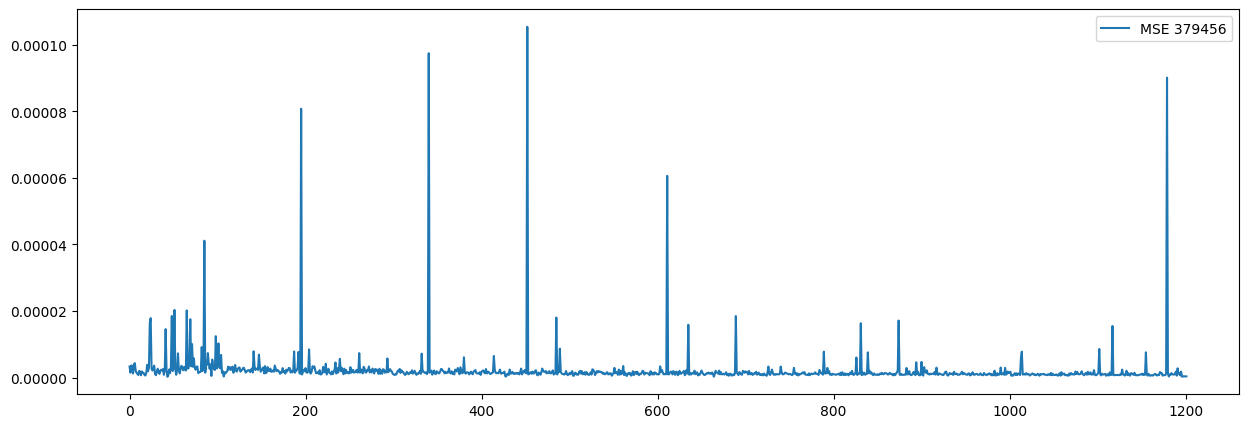

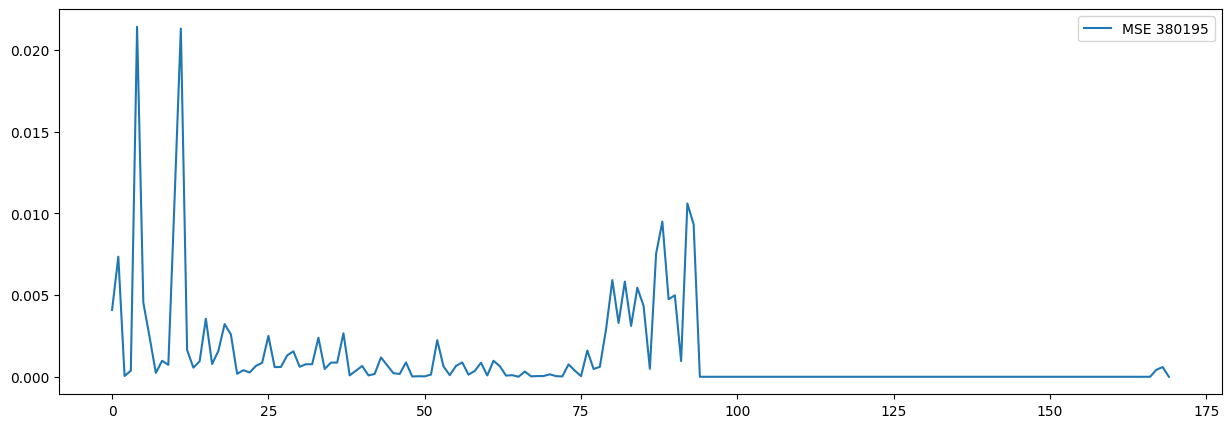

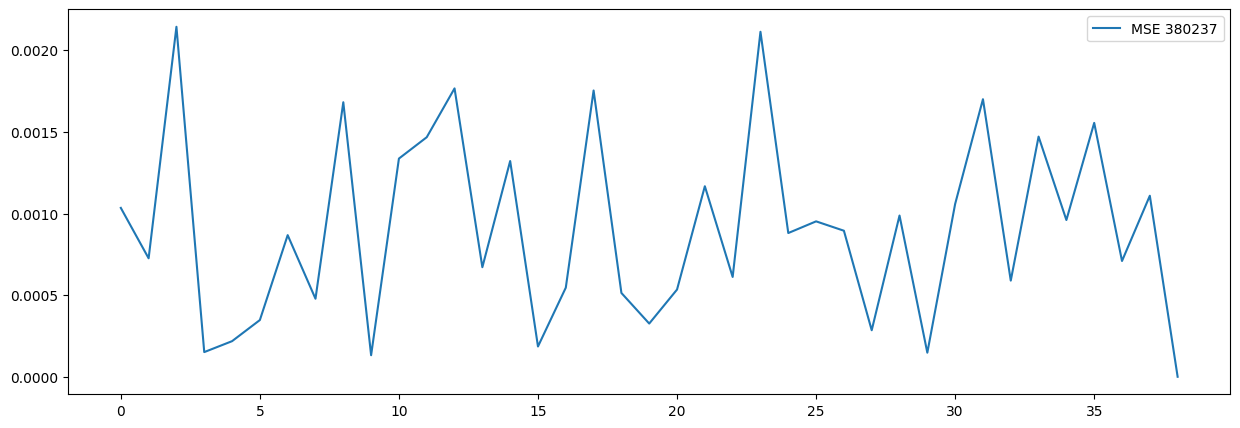

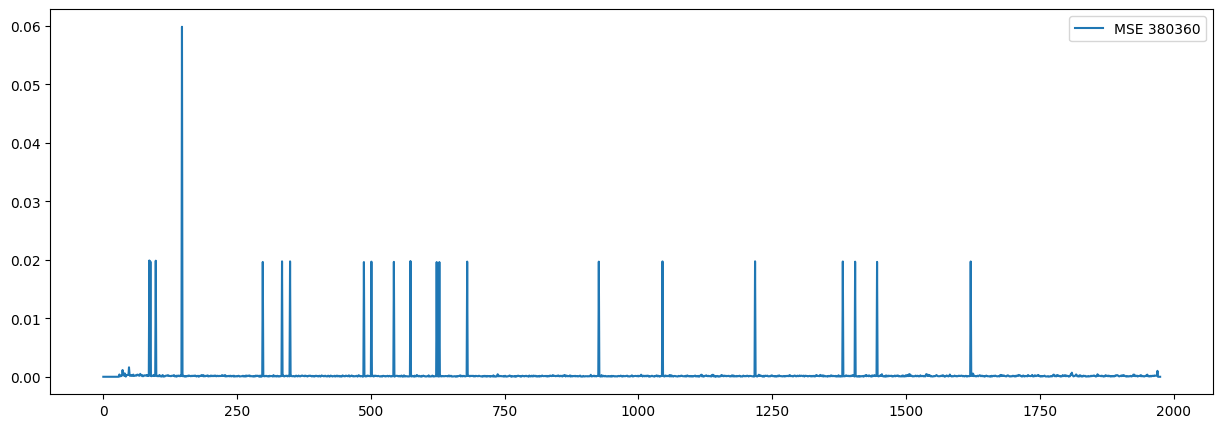

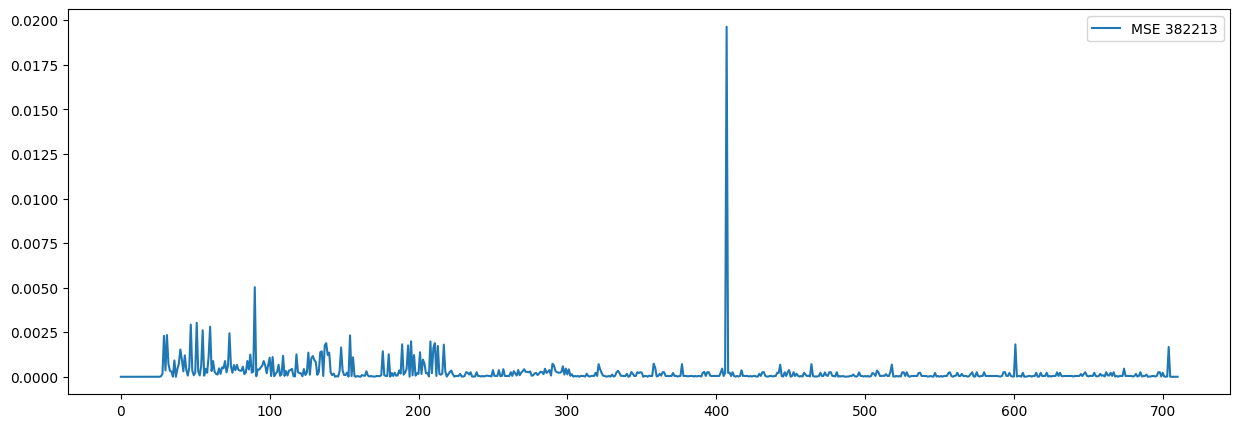

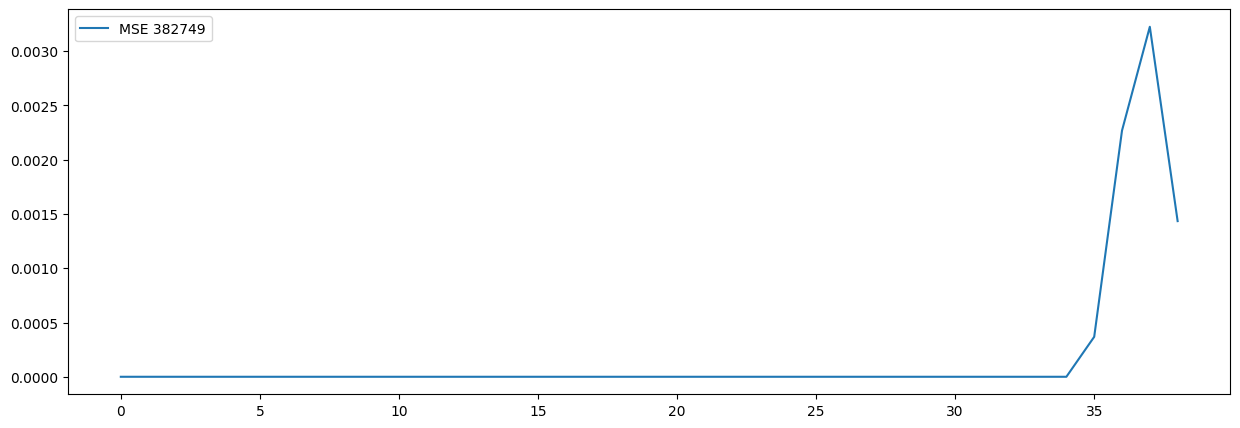

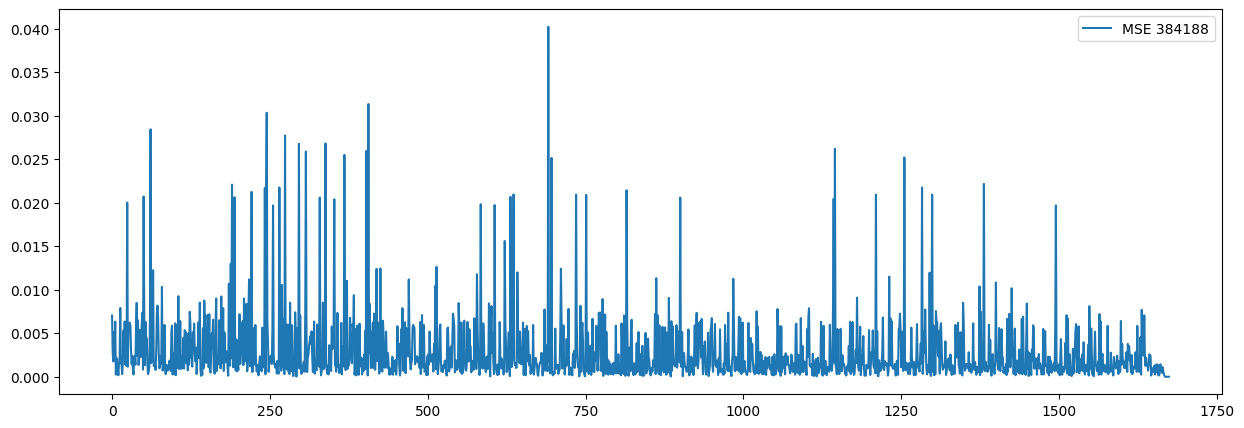

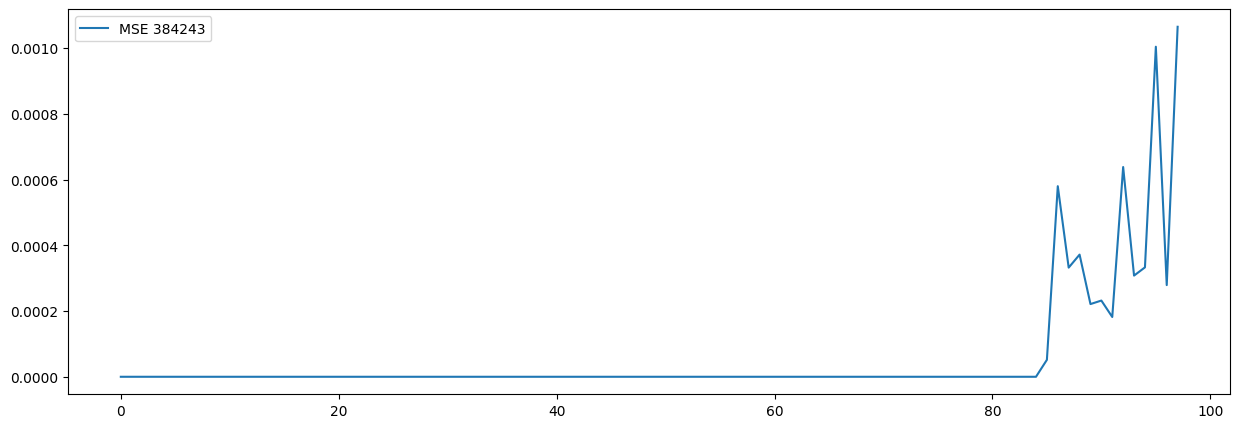

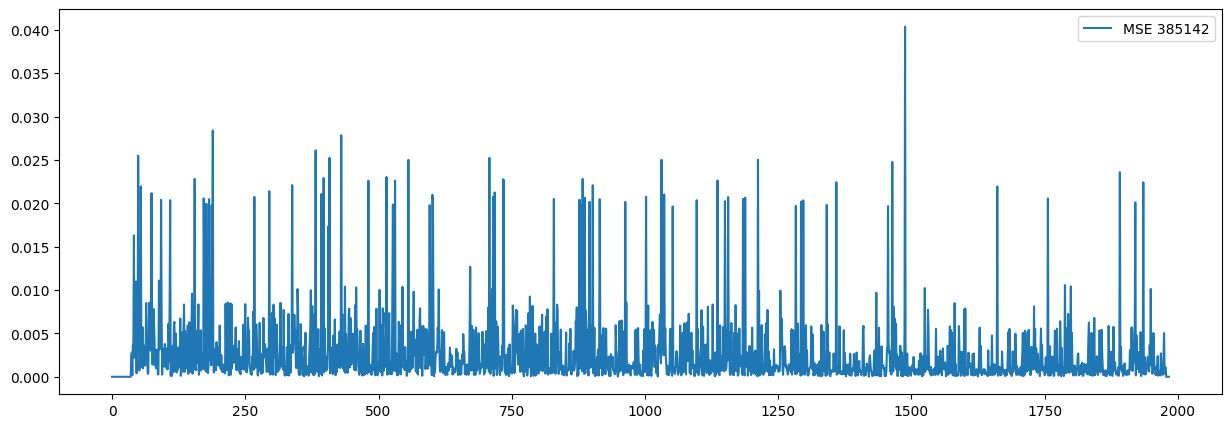

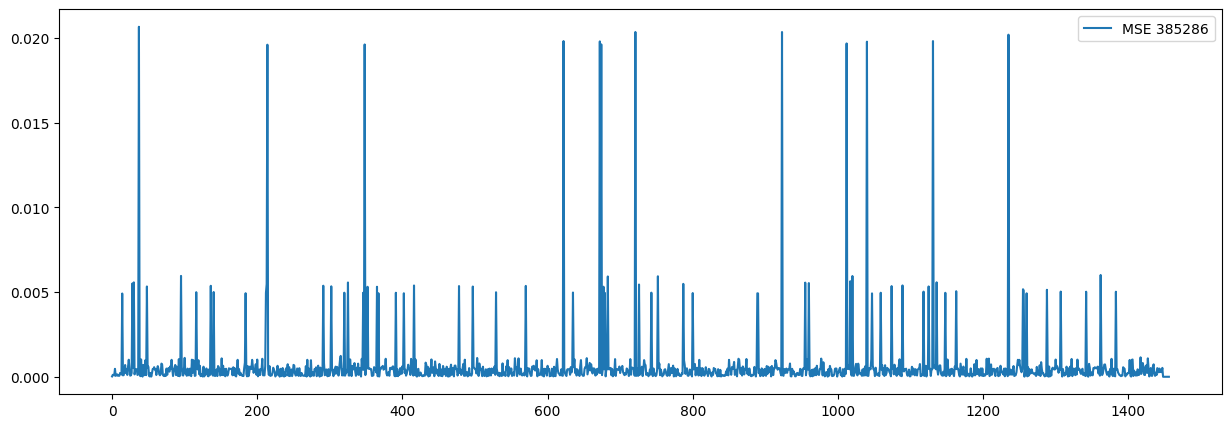

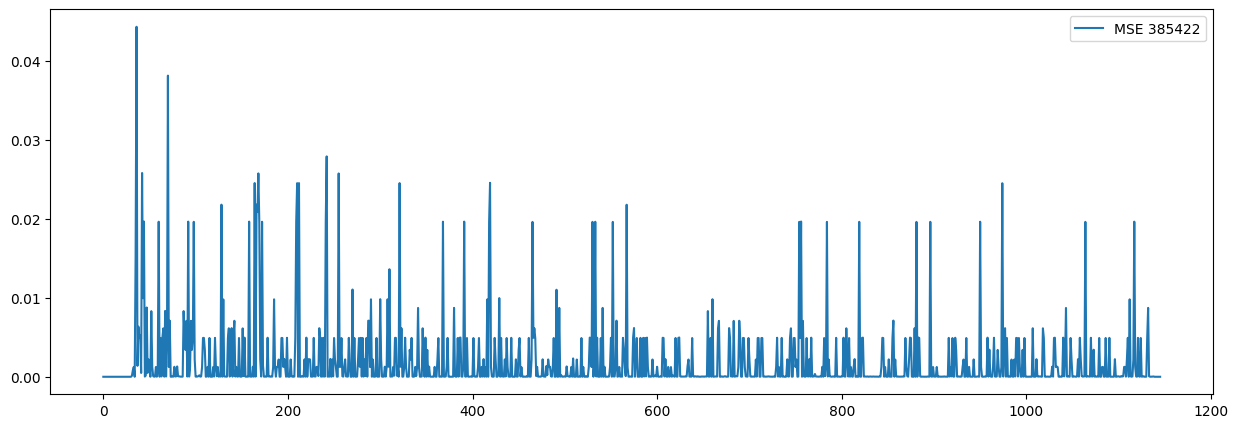

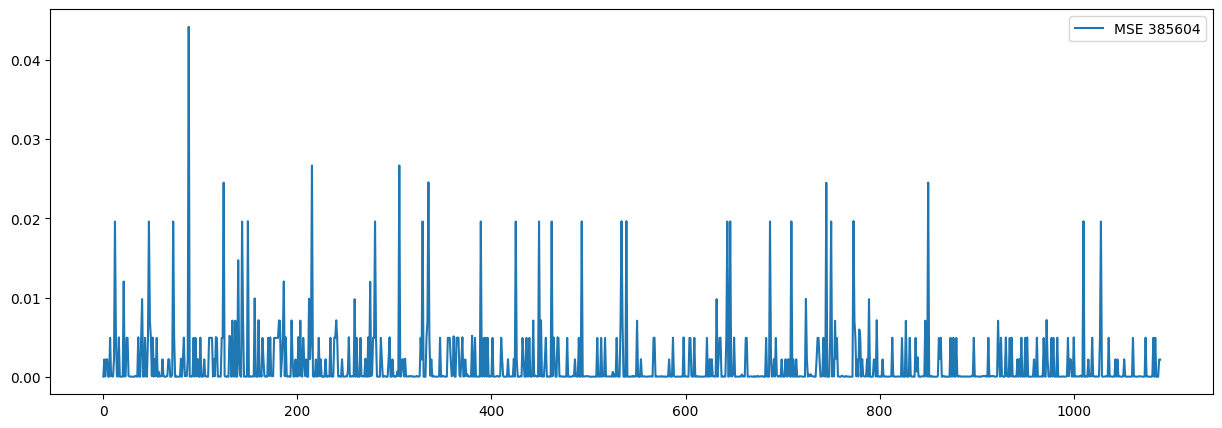

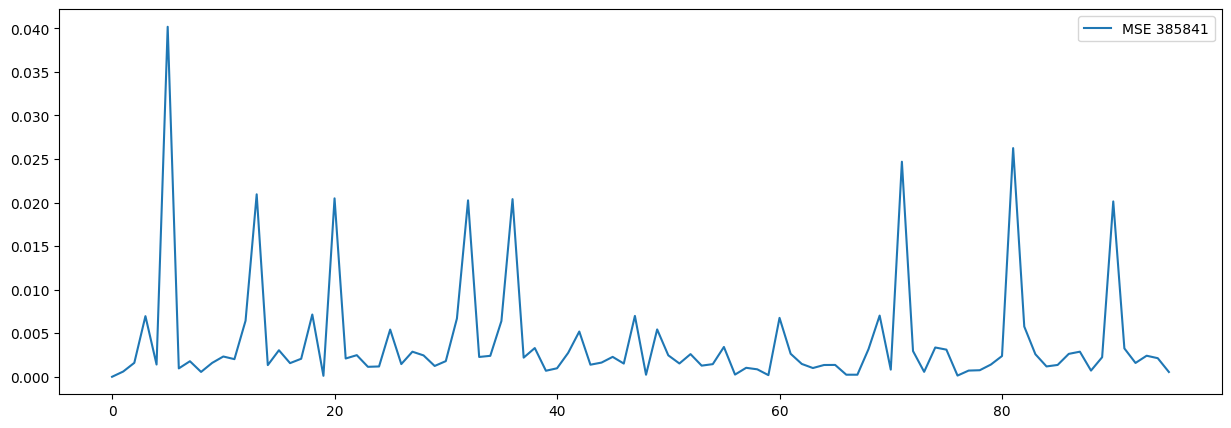

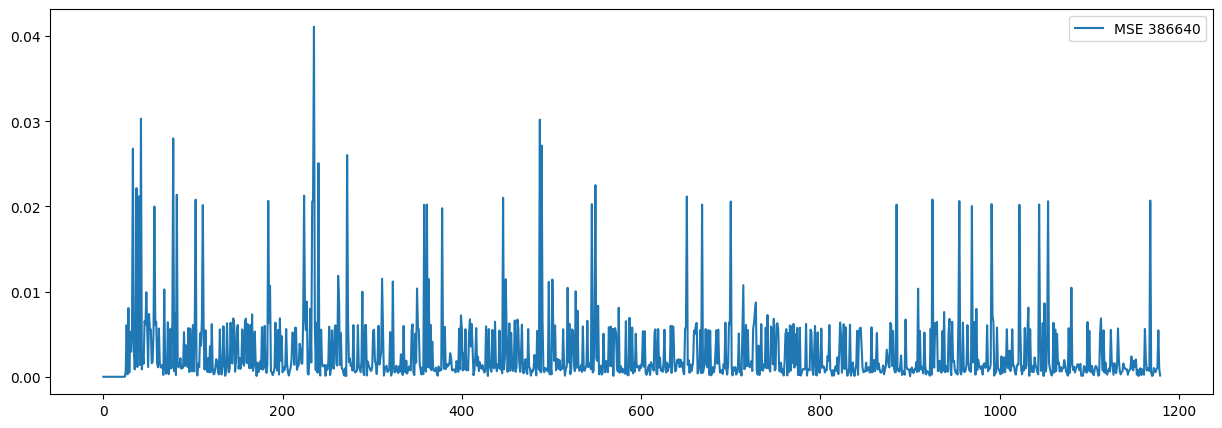

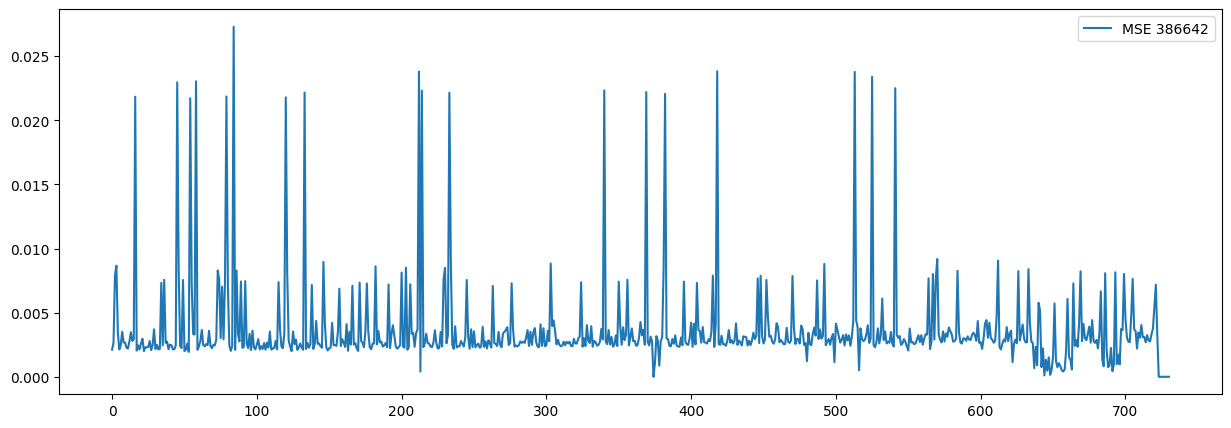

In [8]:
for run_number in np.unique(run_arr):
    test_data = data_arr[run_arr == run_number]

    scaler = MinMaxScaler()
    scaler.fit(test_data)
    test_data = scaler.transform(test_data)
    dtest = xgb.DMatrix(test_data)

    reconstructed = bst.predict(dtest)
    mse = np.mean((test_data - reconstructed)**2, axis=1)

    plt.figure(figsize=(15, 5))
    plt.plot(range(mse.shape[0]), mse, label=f"MSE {run_number}")
    plt.legend()
    plt.show()
    plt.close()

In [9]:
os.makedirs("../models/xgb_regressor", exist_ok=True)
bst.save_model("../models/xgb_regressor/0001.ubj")

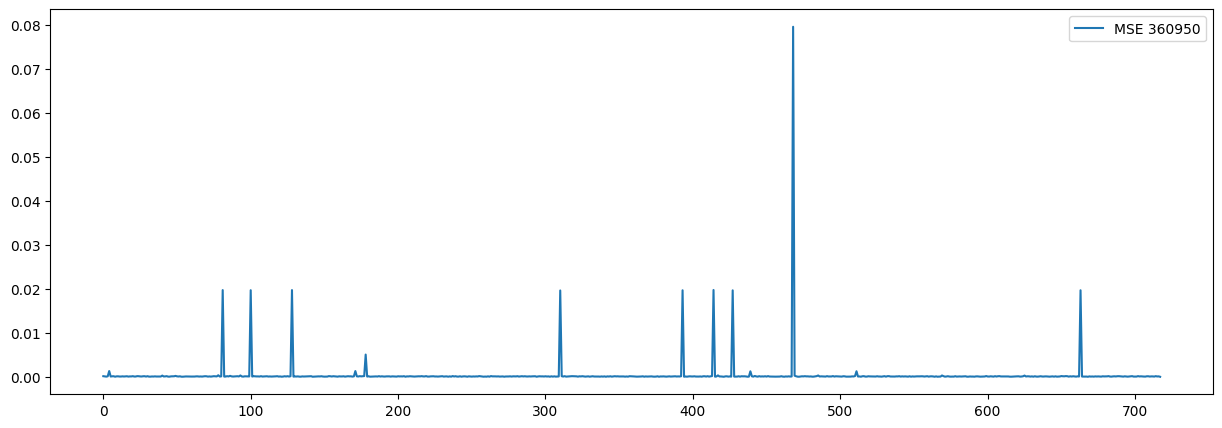

In [14]:
loaded_model = xgb.Booster(model_file="../models/xgb_regressor/0001.ubj")

for run_number in np.unique(run_arr)[:1]:
    test_data = data_arr[run_arr == run_number]
    test_data = MinMaxScaler().fit_transform(test_data)
    reconstructed = loaded_model.predict(xgb.DMatrix(test_data))
    mse = np.mean((test_data - reconstructed)**2, axis=1)

    plt.figure(figsize=(15, 5))
    plt.plot(range(mse.shape[0]), mse, label=f"MSE {run_number}")
    plt.legend()
    plt.show()
    plt.close()